<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#XGBoost-model" data-toc-modified-id="XGBoost-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost model</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning-with-Hyperopt" data-toc-modified-id="Hyperparameter-tuning-with-Hyperopt-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyperparameter tuning with Hyperopt</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model fitting</a></span></li></ul></li><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Saving the model</a></span></li><li><span><a href="#SHAP-values" data-toc-modified-id="SHAP-values-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SHAP values</a></span></li><li><span><a href="#Validation-check" data-toc-modified-id="Validation-check-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validation check</a></span><ul class="toc-item"><li><span><a href="#Submission-XGB-SCORE" data-toc-modified-id="Submission-XGB-SCORE-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Submission XGB SCORE</a></span></li></ul></li><li><span><a href="#Misc" data-toc-modified-id="Misc-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Misc</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree
from lightgbm import LGBMClassifier, plot_tree #LGBMRanker
import math
import pickle
import statsmodels.api as sm


import xgboost as xgb

In [3]:
seed=1234

In [4]:
# file = open("type2id.pkl",'rb')
# object_file = pickle.load(file)

In [5]:
file_name = "otto_xgb_model_14_reduced_lb.pkl"

In [6]:
df=pd.read_parquet('train_sample_full_cv_3targets_experimental_reduced.parquet')#train_sample_full_cv_hidden_targets_float
valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental_reduced.parquet')

In [7]:
# df=df[df['MIN_TOP20']<=60]
# valid=valid[valid['MIN_TOP20']<=60]

In [8]:
# df=pd.concat([df,valid])

In [9]:
df=pd.concat([pd.concat([df[df['TARGET']==1],valid[valid['TARGET']==1]]), pd.concat([df[df['TARGET']==0],valid[valid['TARGET']==0]]).sample(20000000)])

In [10]:
df.columns=[x.lower() for x in df.columns]
# valid.columns=[x.lower() for x in valid.columns]

In [11]:
del valid

In [12]:
# sessions_with_orders=pd.DataFrame(df.groupby('session_id')['target'].sum()).reset_index()
# sessions_with_orders=sessions_with_orders[sessions_with_orders['target']>0]
# df=df.merge(sessions_with_orders['session_id'], how='inner', on='session_id')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20044022 entries, 3955 to 16738599
Data columns (total 51 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   target                          float64
 1   target_clicks                   float64
 2   target_carts                    float64
 3   target_orders                   float64
 4   session_id                      float64
 5   aid                             float64
 6   min_top20                       float64
 7   avg_top20                       float64
 8   max_top20                       float64
 9   in_session                      float64
 10  in_session_clicked              float64
 11  in_session_carted               float64
 12  in_session_ordered              float64
 13  in_session_score                float64
 14  in_session_score_time_weighted  float64
 15  times_in_top20                  float64
 16  times_in_top20_last_week        float64
 17  min_order_hours_from_c

In [14]:
df.head()

target  target_clicks  target_carts  target_orders  session_id  \
3955      1.0            0.0           1.0            0.0   8915456.0   
4971      1.0            0.0           1.0            1.0   8915529.0   
9318      1.0            0.0           1.0            0.0   8939238.0   
10702     1.0            1.0           1.0            0.0   8915653.0   
11065     1.0            1.0           1.0            0.0   8915711.0   

             aid  min_top20  avg_top20  max_top20  in_session  ...  \
3955   1477709.0       16.0       16.0       16.0         0.0  ...   
4971   1042356.0       40.0       40.0       40.0         0.0  ...   
9318   1022584.0        3.0        3.0        3.0         0.0  ...   
10702  1187871.0        2.0        2.0        2.0         0.0  ...   
11065    11138.0        0.0        1.0        2.0         1.0  ...   

       number_orders  first_seen   last_seen  first_bought  last_bought  \
3955             0.0  492.768454   76.007007    434.624293   172.052346   
4971             2.0  445.161904  146.502547    173.369225   171.248593   
9318             0.0  503.006727    3.544176    487.563191   119.895292   
10702            0.0  503.993316    0.519922    502.863066     8.198534   
11065            0.0  447.377744  150.790205    447.377744   447.342725   

       bought_overall  seen_overall  num_clicks_same_day  num_carts_same_day  \
3955              7.0         152.0                  NaN                 NaN   
4971              3.0          17.0                  1.0                 0.0   
9318             21.0         213.0                  4.0                 0.0   
10702           196.0        6167.0                 78.0                 1.0   
11065             2.0           7.0                  2.0                 0.0   

       num_orders_same_day  
3955                   NaN  
4971                   0.0  
9318                   0.0  
10702                  0.0  
11065                  0.0  

[5 rows x 51 columns]

In [15]:
df['null_flag']=(df['avg_order_hours_from_click_avg']<99999).apply(int)
df['in_session_carted_not_ordered']=((df['in_session_carted']>0)&(df['in_session_ordered']==0)).apply(int)
df['in_session_clicked_not_carted']=((df['in_session_clicked']>0)&(df['in_session_carted']==0)).apply(int)

df['in_session_clicked_not_ordered']=((df['in_session_clicked']>0)&(df['in_session_ordered']==0)).apply(int)
df['min_top20_x_in_session_score_time_weighted']=df['min_top20']*df['in_session_score_time_weighted']
df['avg_top20_x_in_session_score_time_weighted']=df['avg_top20']*df['in_session_score_time_weighted']
df['num_clicks_same_day_x_num_carts_same_day']=df['num_clicks_same_day']*df['num_carts_same_day']
df['num_clicks_same_day_x_num_orders_same_day']=df['num_clicks_same_day']*df['num_orders_same_day']
df['num_carts_same_day_x_num_orders_same_day']=df['num_carts_same_day']*df['num_orders_same_day']


# valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
# valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
# valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)

In [16]:
df['null_flag'].value_counts(normalize=True)

1    0.712922
0    0.287078
Name: null_flag, dtype: float64

In [17]:
df['target'].value_counts()

0.0    20000000
1.0       44022
Name: target, dtype: int64

In [18]:
#df=df[df['null_flag']==1].reset_index()
#valid=valid[valid['null_flag']==1].reset_index()

In [19]:
df['target'].value_counts()

0.0    20000000
1.0       44022
Name: target, dtype: int64

In [20]:
# rand=np.random.randint(1, 11, df.shape[0])

# train_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand<=8
# valid_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand>8

In [21]:
# df[train_mask]['target'].value_counts()

In [22]:
# df[valid_mask]['target'].value_counts()

In [23]:
col_target='target'
col_exclude=[
'session_id',
'aid',
# 'num_times_ordered_overall',
'number_carts_orders',
'number_carts',
'number_orders',
'sess_days_till_test',
'sess_dayofmonth',
# 'in_session',
# 'in_session_clicked',
# 'in_session_carted',
#  'in_session_ordered',
#  'in_session_score',
# 'first_seen',
# 'first_bought',

'target_clicks',
'target_carts',
'target_orders',
col_target,]

In [24]:
# df[col_target]=df[col_target].apply(int)

# Data exploration

In [25]:
col_preds=[col for col in df.columns[3:] if col not in col_exclude]

In [26]:
len(col_preds)

49

In [27]:
col_preds

['min_top20',
 'avg_top20',
 'max_top20',
 'in_session',
 'in_session_clicked',
 'in_session_carted',
 'in_session_ordered',
 'in_session_score',
 'in_session_score_time_weighted',
 'times_in_top20',
 'times_in_top20_last_week',
 'min_order_hours_from_click_avg',
 'avg_order_hours_from_click_avg',
 'avg_num_sessions_ordered',
 'sum_num_sessions_ordered',
 'avg_num_occured_overall',
 'sum_num_occured_overall',
 'last_num_sessions_ordered',
 'last_hour_num_sessions_ordered',
 'num_times_ordered_overall',
 'sess_num_events',
 'sess_num_clicks',
 'sess_num_carts',
 'sess_num_orders',
 'sess_num_clicks_last_hour',
 'sess_num_carts_last_hour',
 'sess_num_orders_last_hour',
 'sess_duration',
 'sess_minute',
 'sess_hour',
 'sess_dayofweek',
 'first_seen',
 'last_seen',
 'first_bought',
 'last_bought',
 'bought_overall',
 'seen_overall',
 'num_clicks_same_day',
 'num_carts_same_day',
 'num_orders_same_day',
 'null_flag',
 'in_session_carted_not_ordered',
 'in_session_clicked_not_carted',
 'in_s

# XGBoost model

## Hyperparameter tuning with Hyperopt

In [28]:
# from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

# sample_train=df.sample(250000)
# sample_valid=df.sample(100000)

# space={'max_depth': hp.quniform("max_depth", 3, 6, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 100,
#         'seed': 0
#     }

# def objective(space):
#     clf=xgb.XGBClassifier(
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']))
    
#     evaluation = [( sample_train[col_preds], sample_train[col_target]), ( sample_valid[col_preds], sample_valid[col_target])]
    
#     clf.fit(sample_train[col_preds], sample_train[col_target],
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)
    

#     pred = clf.predict_proba(sample_valid[col_preds])[:, 1]
#     gini = mofr.metrics.gini(sample_valid[col_target], pred)
#     print ("SCORE:", gini)
#     return {'loss': -gini, 'status': STATUS_OK }

# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 33,
#                         trials = trials)

# del sample_train
# del sample_valid

# hyperparams_name = "best_hyperparams_cv.pkl"

# # save
# pickle.dump(best_hyperparams, open(hyperparams_name, "wb"))

## Model fitting

In [29]:
hyperparams_name = "best_hyperparams_cv.pkl"
best_hyperparams= pickle.load(open(hyperparams_name, "rb"))

In [30]:
best_hyperparams['max_depth']=int(best_hyperparams['max_depth'])
# best_hyperparams['max_depth']=4
# best_hyperparams

In [31]:
# train=df[train_mask]#&(df['null_flag']==1)
# print(train['session_id'].max())
# train[col_target].value_counts()

In [32]:
xgb_model = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=100)
# xgb_model = XGBClassifier(**best_hyperparams)##

xgb_model.fit(df.loc[:, col_preds], df[col_target], verbose=0, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, ...)

In [33]:
df['XGB_SCORE']=xgb_model.predict_proba(df[col_preds])[:, 1]
# train['XGB_SCORE']=xgb_model.predict_proba(train[col_preds])[:, 1]
# valid['XGB_SCORE']=xgb_model.predict_proba(valid[col_preds])[:, 1]

In [34]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[col_target], df['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[col_target].apply(int), df['XGB_SCORE'])))
# print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
# print('The Lift on the valid set is: '+ str(mofr.metrics.lift(valid[col_target], valid['XGB_SCORE'])))
# print('The gini on the valid set is: '+ str(mofr.metrics.gini(valid[col_target].apply(int), valid['XGB_SCORE'])))
# # print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')

The Lift on the train set is: 9.0261651312784
The gini on the train set is: 0.9315725352403339




In [35]:
# from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
# df['one']=1

# rce=ROCCurveEvaluator()
# rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE'])
# rce.get_graph()

# del df['one']

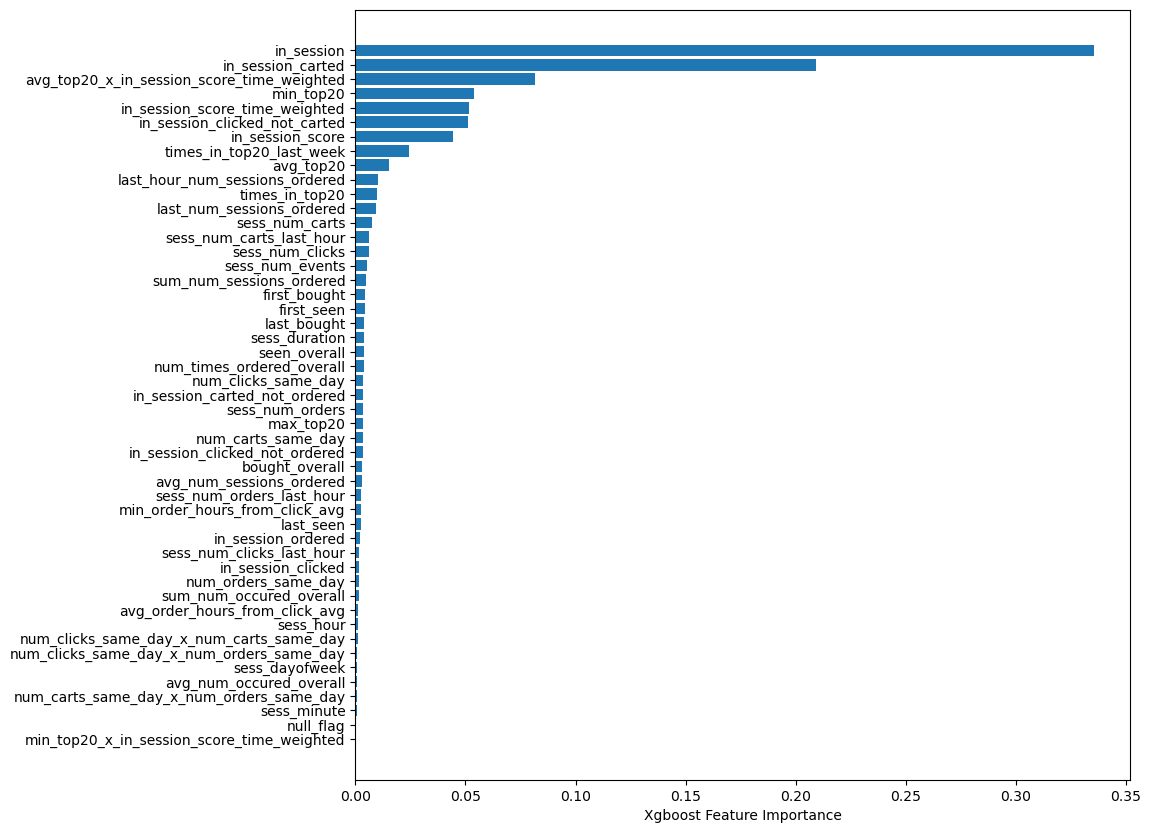

In [36]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(xgb_model.feature_names_in_[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

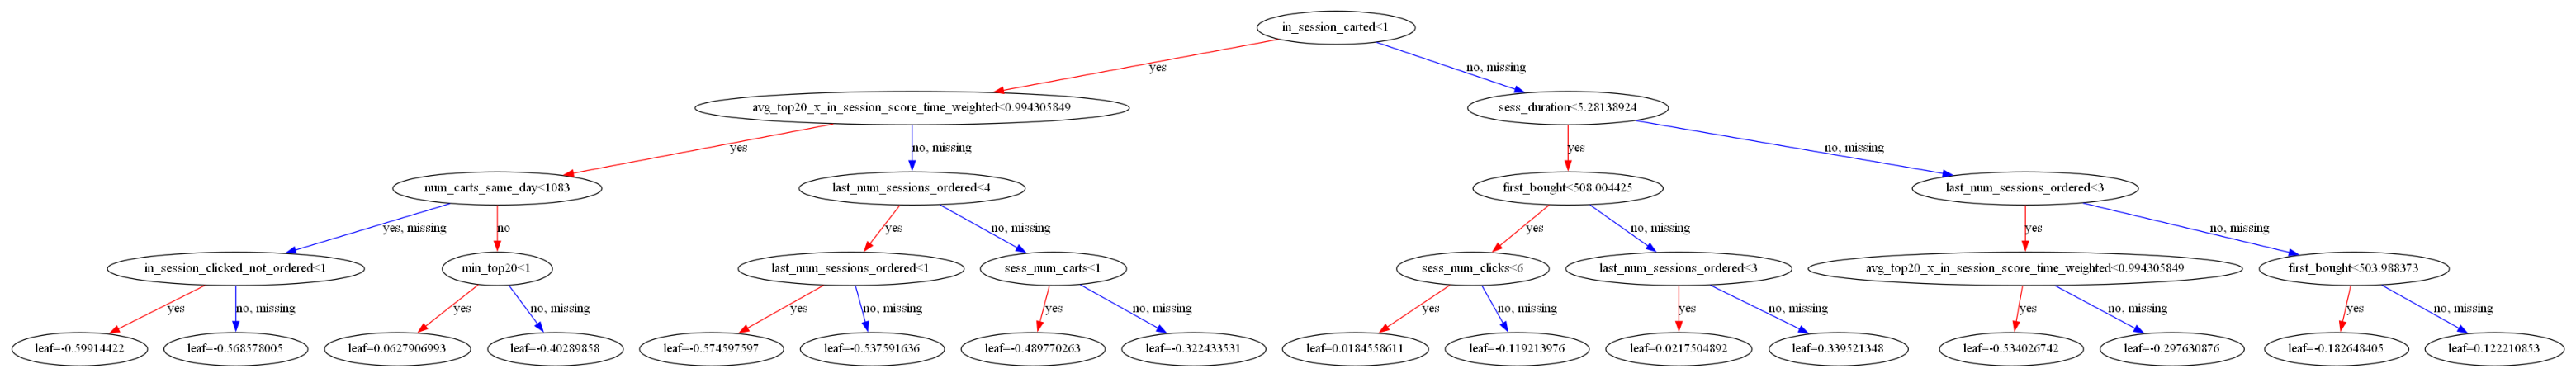

In [37]:
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files/Graphviz/bin/'

from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (40,40)
plot_tree(xgb_model)
plt.show()

In [38]:
# results=[]
# for col in col_preds:
#     results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
# pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

# Saving the model

In [39]:
#file_name = "otto_xgb_model_10_3weeks_no_nulls.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

# SHAP values

In [40]:
import shap  # package used to calculate Shap values
row_to_show = 1
data_for_prediction = df[col_preds].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

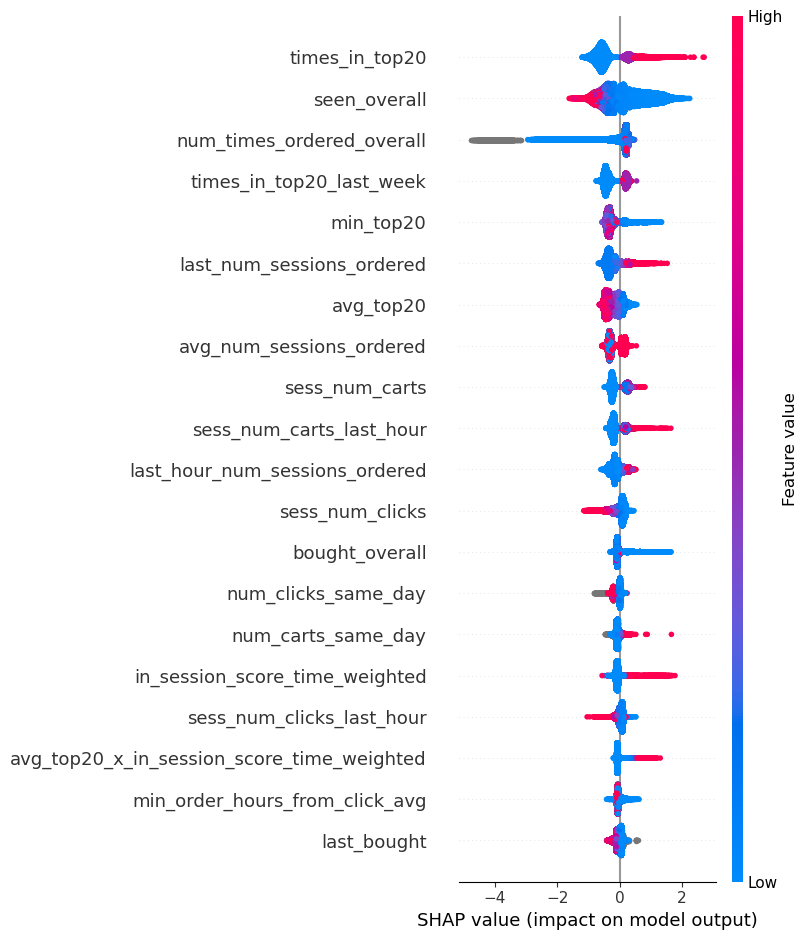

In [41]:
sample=df[col_preds].sample(100000)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample[col_preds])

In [42]:
sample=df.sample(100000)
results=[]
for col in col_preds:
    results.append((col, mofr.metrics.gini(sample[col_target], sample[col].fillna(-999))))

pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)

Predictor      GINI
10                    times_in_top20_last_week  0.746331
18              last_hour_num_sessions_ordered  0.706621
14                    sum_num_sessions_ordered  0.685119
16                     sum_num_occured_overall  0.670584
8               in_session_score_time_weighted  0.664502
7                             in_session_score  0.663301
45  avg_top20_x_in_session_score_time_weighted  0.660938
3                                   in_session  0.658691
13                    avg_num_sessions_ordered  0.630775
9                               times_in_top20  0.616276
4                           in_session_clicked  0.603276
43              in_session_clicked_not_ordered  0.588225
15                     avg_num_occured_overall  0.585018
17                   last_num_sessions_ordered  0.570349
5                            in_session_carted  0.357494
41               in_session_carted_not_ordered  0.337412
38                          num_carts_same_day  0.327901
25                    sess_num_carts_last_hour  0.303065
42               in_session_clicked_not_carted  0.296167
46    num_clicks_same_day_x_num_carts_same_day  0.282536
22                              sess_num_carts  0.266777
39                         num_orders_same_day  0.253651
48    num_carts_same_day_x_num_orders_same_day  0.252976
47   num_clicks_same_day_x_num_orders_same_day  0.252305
40                                   null_flag  0.242125
37                         num_clicks_same_day  0.143750
19                   num_times_ordered_overall  0.104804
35                              bought_overall  0.085993
24                   sess_num_clicks_last_hour  0.083436
28                                 sess_minute  0.051257
20                             sess_num_events  0.043001
6                           in_session_ordered  0.025112
26                   sess_num_orders_last_hour  0.011762
29                                   sess_hour  0.010178
44  min_top20_x_in_session_score_time_weighted  0.000000
33                                first_bought -0.006488
21                             sess_num_clicks -0.007511
23                             sess_num_orders -0.011841
36                                seen_overall -0.030300
27                               sess_duration -0.042327
30                              sess_dayofweek -0.063628
32                                   last_seen -0.079041
31                                  first_seen -0.081950
34                                 last_bought -0.193597
12              avg_order_hours_from_click_avg -0.250054
2                                    max_top20 -0.398826
11              min_order_hours_from_click_avg -0.441068
1                                    avg_top20 -0.769399
0                                    min_top20 -0.868563

In [43]:
del sample

# Validation check

In [44]:
del df
# del train

In [45]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
import math
import pickle


import xgboost as xgb

In [46]:
# file_name = "otto_xgb_model_13_experimenting_lb_586.pkl"

# #load
# xgb_model= pickle.load(open(file_name, "rb"))

In [47]:
col_target='target'

In [48]:
valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental.parquet')
valid.columns=[x.lower() for x in valid.columns]
valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)

valid['in_session_clicked_not_ordered']=((valid['in_session_clicked']>0)&(valid['in_session_ordered']==0)).apply(int)
valid['min_top20_x_in_session_score_time_weighted']=valid['min_top20']*valid['in_session_score_time_weighted']
valid['avg_top20_x_in_session_score_time_weighted']=valid['avg_top20']*valid['in_session_score_time_weighted']
valid['num_clicks_same_day_x_num_carts_same_day']=valid['num_clicks_same_day']*valid['num_carts_same_day']
valid['num_clicks_same_day_x_num_orders_same_day']=valid['num_clicks_same_day']*valid['num_orders_same_day']
valid['num_carts_same_day_x_num_orders_same_day']=valid['num_carts_same_day']*valid['num_orders_same_day']


valid['XGB_SCORE']=xgb_model.predict_proba(valid[xgb_model.feature_names_in_])[:, 1]

In [49]:
# result=[]
# for i in [100,90,80,70,60,50,40,30]:
#     valid_=valid[valid['min_top20']<=i]
#     gini=mofr.metrics.gini(valid_[col_target], valid_['XGB_SCORE'])
#     a=valid_[['session_id', 'aid', 'XGB_SCORE',col_target]].groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
#     num_captured=np.sum(a[col_target])
#     print (i,gini, num_captured)
#     result.append((i,gini, num_captured))
    
# pd.DataFrame(result)

In [50]:
valid.head()

target  target_clicks  target_carts  target_orders  session_id     aid  \
0     0.0            0.0           0.0            0.0  11098546.0   605.0   
1     0.0            0.0           0.0            0.0  11098546.0   665.0   
2     0.0            0.0           0.0            0.0  11098546.0  1089.0   
3     0.0            0.0           0.0            0.0  11098546.0  1303.0   
4     0.0            0.0           0.0            0.0  11098546.0  1398.0   

   min_top20  avg_top20  max_top20  in_session  ...  null_flag  \
0        9.0  50.000000       91.0         0.0  ...          1   
1       71.0  71.000000       71.0         0.0  ...          0   
2       16.0  45.666667       82.0         0.0  ...          1   
3       35.0  60.500000       87.0         0.0  ...          1   
4       15.0  15.000000       15.0         0.0  ...          0   

   in_session_carted_not_ordered  in_session_clicked_not_carted  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   in_session_clicked_not_ordered  min_top20_x_in_session_score_time_weighted  \
0                               0                                         0.0   
1                               0                                         0.0   
2                               0                                         0.0   
3                               0                                         0.0   
4                               0                                         0.0   

   avg_top20_x_in_session_score_time_weighted  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   num_clicks_same_day_x_num_carts_same_day  \
0                                       9.0   
1                                       0.0   
2                                     127.0   
3                                     160.0   
4                                       NaN   

   num_clicks_same_day_x_num_orders_same_day  \
0                                        9.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        NaN   

   num_carts_same_day_x_num_orders_same_day  XGB_SCORE  
0                                       1.0   0.000211  
1                                       0.0   0.000071  
2                                       0.0   0.000090  
3                                       0.0   0.000264  
4                                       NaN   0.000911  

[5 rows x 61 columns]

In [51]:
valid[col_target].value_counts()

0.0    28769561
1.0       38983
Name: target, dtype: int64

In [52]:
# coverage=(pd.DataFrame(df.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(df.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the train set is: {target_coverage}')
# print(f'The mean coverage of carts on the train set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the train set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

In [53]:
# coverage=(pd.DataFrame(valid.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(valid.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the valid set is: {target_coverage}')
# print(f'The mean coverage of carts on the valid set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the valid set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

## Submission XGB SCORE

In [54]:
a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
pred_df=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [55]:
# a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['in_session','times_in_top20','XGB_SCORE'], ascending = [False,False,False]).head(20).reset_index(drop = True)).reset_index(drop = True)
# a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
# a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
# pred_df=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [56]:
# TOP CLICKS AND ORDERS IN TEST
top_clicks = ['485256', '1460571','108125','1551213','33343','613493','876493','152547','184976','1236775'
              ,'1406660','836852','331708','1531805','29735','554660','634452','986164','959208','832192']

top_carts = ['485256', '33343','613493','152547','876493','1406660','1736857','166037','1460571','1236775'
             ,'554660','660655','1531805','1022566','231487','122983','1562705','923948','332654','544144']

top_orders = ['876493', '1406660','1236775','166037','1460571','1531805','836852','634452','923948','1043508'
             ,'832192','258353','801774','332654','1596897','29735','544144','1581568','1462420','1006198']

In [57]:
submission_clicks_valid=pred_df.copy()
submission_carts_valid=pred_df.copy()
submission_orders_valid=pred_df.copy()

submission_clicks_valid['session_type']=submission_clicks_valid['session_id'].apply(lambda x: x+'_clicks')
submission_carts_valid['session_type']=submission_carts_valid['session_id'].apply(lambda x: x+'_carts')
submission_orders_valid['session_type']=submission_orders_valid['session_id'].apply(lambda x: x+'_orders')     

In [58]:
submission_clicks_valid['labels']=submission_clicks_valid['labels'].apply(lambda x: list(x.split(' ')) + top_clicks).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_carts_valid['labels']=submission_carts_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_orders_valid['labels']=submission_orders_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))

In [59]:
submission_final_valid=pd.concat([submission_clicks_valid[['session_type', 'labels']],submission_carts_valid[['session_type', 'labels']],submission_orders_valid[['session_type', 'labels']]])

In [60]:
# COMPUTE METRIC
score = 0
weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}
for t in ['clicks','carts','orders']:
    sub = submission_final_valid.loc[submission_final_valid.session_type.str.contains(t)].copy()
    sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
    test_labels = pd.read_parquet('test_cv_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==t]
    test_labels = test_labels.merge(sub, how='inner', on=['session'])
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    score += weights[t]*recall
    print(f'{t} recall =',recall)
    
print('=============')
print('Overall Recall =',score)
print('=============')

clicks recall = 0.4978439541556568
carts recall = 0.43498471252081833
orders recall = 0.6610714285714285
Overall Recall = 0.5769226663146683


# Misc